# 5.4 SVM工作原理

## 5.4.1 决策函数和预测

线性SVM分类器通过简单地计算决策函数来 $\mathbf{w^T} \mathbf{x} +b = w_1 x_1 + \cdots + w_n x_n + b$ 预测新实例 $x$ 的分类。如果结果为正，则预测类别是正类（1），否则预测其为负类（0），见公式5-2。

$$
\hat{y} = \begin{cases}
0 & \text{if } \mathbf{w^T} + b \lt 0 \\
1 & \text{if } \mathbf{w^T} + b \ge 0 
\end{cases}
$$





In [1]:
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn import datasets

In [2]:
iris = datasets.load_iris()
X = iris['data'][:, (2, 3)]
y = (iris['target']== 2).astype(np.float64)
X.shape, y.shape

((150, 2), (150,))

In [3]:
from mpl_toolkits.mplot3d import Axes3D

In [4]:
def plot_3D_decision_function(ax, w, b, x1_lim=[4, 6], x2_lim=[0.8, 2.8]):
    x1_in_bounds = (X[:, 0] > x1_lim[0]) & (X[:, 0] < x1_lim[1])
    X_crop = X[x1_in_bounds]
    y_crop = y[x1_in_bounds]
    x1s = np.linspace(x1_lim[0], x1_lim[1], 20)
    x2s = np.linspace(x2_lim[0], x2_lim[1], 20)
    x1, x2 = np.meshgrid(x1s, x2s)
    xs = np.c_[x1.ravel(), x2.ravel()]
    df = (xs.dot(w) + b).reshape(x1.shape)
    m = 1 / np.linalg.norm(w)
    boundary_x2s = -x1s*(w[0]/w[1])-b/w[1]
    margin_x2s_1 = -x1s*(w[0]/w[1])-(b-1)/w[1]
    margin_x2s_2 = -x1s*(w[0]/w[1])-(b+1)/w[1]
    ax.plot_surface(x1s, x2, np.zeros_like(x1),
                    color="b", alpha=0.2, cstride=100, rstride=100)
    ax.plot(x1s, boundary_x2s, 0, "k-", linewidth=2, label=r"$h=0$")
    ax.plot(x1s, margin_x2s_1, 0, "k--", linewidth=2, label=r"$h=\pm 1$")
    ax.plot(x1s, margin_x2s_2, 0, "k--", linewidth=2)
    ax.plot(X_crop[:, 0][y_crop==1], X_crop[:, 1][y_crop==1], 0, "g^")
    ax.plot_wireframe(x1, x2, df, alpha=0.3, color="k")
    ax.plot(X_crop[:, 0][y_crop==0], X_crop[:, 1][y_crop==0], 0, "bs")
    ax.axis(x1_lim + x2_lim)
    ax.text(4.5, 2.5, 3.8, "Decision function $h$", fontsize=15)
    ax.set_xlabel(r"Petal length", fontsize=15)
    ax.set_ylabel(r"Petal width", fontsize=15)
    ax.set_zlabel(r"$h = \mathbf{w}^T \mathbf{x} + b$", fontsize=18)
    ax.legend(loc="upper left", fontsize=16)



In [5]:
from sklearn.svm import LinearSVC
from sklearn.preprocessing import StandardScaler

svc_clf2 = LinearSVC(C=100, loss="hinge", random_state=42)


svc_clf2.fit(X, y)

LinearSVC(C=100, loss='hinge', random_state=42)

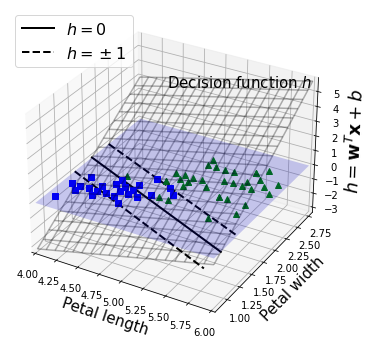

In [6]:
fig = plt.figure(figsize=(11, 6))
ax1 = fig.add_subplot(111, projection='3d')
plot_3D_decision_function(ax1, w=svc_clf2.coef_[0], b=svc_clf2.intercept_[0])

plt.show()

## 5.4.2 训练目标

决策函数的斜率：它等于权重向量的范数，即 $||\mathbf{w}||$ 。如果我们将斜率除以2，那么决策函数等于±1的点也将变得离决策函数两倍远。也就是说，将斜率除以2，将会使间隔乘以2。也许2D图更容易将其可视化，见图5-13。

**权重向量w越小，间隔越大**


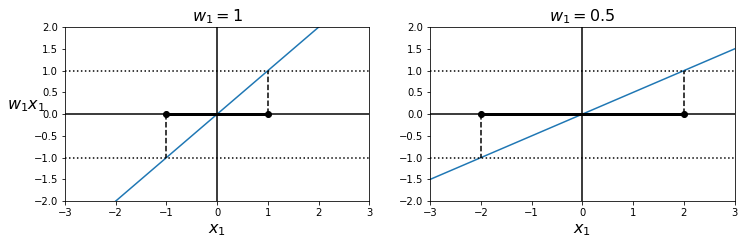

In [7]:
def plot_2D_decision_function(w, b, ylabel=True, x1_lim=[-3, 3]):
    x1 = np.linspace(x1_lim[0], x1_lim[1], 200)
    y = w * x1 + b
    m = 1 / w

    plt.plot(x1, y)
    plt.plot(x1_lim, [1, 1], "k:")
    plt.plot(x1_lim, [-1, -1], "k:")
    plt.axhline(y=0, color='k')
    plt.axvline(x=0, color='k')
    plt.plot([m, m], [0, 1], "k--")
    plt.plot([-m, -m], [0, -1], "k--")
    plt.plot([-m, m], [0, 0], "k-o", linewidth=3)
    plt.axis(x1_lim + [-2, 2])
    plt.xlabel(r"$x_1$", fontsize=16)
    if ylabel:
        plt.ylabel(r"$w_1 x_1$  ", rotation=0, fontsize=16)
    plt.title(r"$w_1 = {}$".format(w), fontsize=16)

plt.figure(figsize=(12, 3.2))
plt.subplot(121)
plot_2D_decision_function(1, 0)
plt.subplot(122)
plot_2D_decision_function(0.5, 0, ylabel=False)
plt.show()

我们要最小化 $||\mathbf{w}||$ 来得到尽可能大的间隔。但是，如果我们想避免任何间隔违例（硬间隔），那么就要使所有正类训练集的决策函数大于1，负类训练集的决策函数小于-1. 如果我们定义实例为负类（如果 $y^{(i)}=0$ ）时，$t^{(i)}=-1$ ；实例为正类（如果$y^{(i)}=1$）时，$t^{(i)}=1$。那么就可以将这个约束条件表示为：对所有实例来说，$t^{(i)}(\mathbf{w}^T \cdot \mathbf{x}^{(i)} + b) \ge 1$

因此，我们可以将硬间隔线性SVM分类器的目标看作一个约束优化问题:

$$
\underset{\mathbf{w}, b}{\text{minimize}} \frac{1}{2} \mathbf{w}^T
 \mathbf{w} 

 $$

 $$

 \text{使得}t^{(i)}(\mathbf{w}^T \cdot \mathbf{x}^{(i)} + b) \ge 1, i= 1, 2, \cdots, m
 $$

我们要最小化 $\frac{1}{2} w^T w$ (这等于 $\frac{1}{2} {||w||}^2$ ), 而不是最小化$||w||$， 的确，  $\frac{1}{2} {||w||}^2$有一个很好的简单的导数(是$w$)，而$||w||$在$w=0$时不可微。

要达到软间隔的目标，我们需要为每一个实例引入一个松弛变量$\zeta^{(i)} \ge 0$, $\zeta^{(i)}$衡量的是第$i$个实例多大程度上允许间隔违例。那么现在我们有了两个互相冲突的目标：使松弛变量越小越好从而减少间隔违例，同时还要使$w^T \cdot w/2$最小化以增大间隔。这正是超参数$C$的用武之地：允许我们在两个目标之间权衡.

软间隔线性SVM分类器目标:

$$
\underset{\mathbf{w}, b, \zeta}{\text{minimize}} \frac{1}{2} \mathbf{w}^T \mathbf{w} + C \sum_{i=1}^m \zeta^{(i)}
 \mathbf{w} 

 $$

 $$

 \text{使得}t^{(i)}(\mathbf{w}^T \cdot \mathbf{x}^{(i)} + b) \ge 1 - \zeta^{(i)} \text{和} \zeta^{(i)} \ge 0, i= 1, 2, \cdots, m
 $$



## 5.4.3 二次规划

硬间隔和软间隔问题都属于线性约束的凸二次优化问题。这类问题被称为二次规划（QP）问题

公式5-5：二次规划问题

$$
\underset{\mathbf{p}}{\text{minimize}} \frac{1}{2} \mathbf{p}^T \mathbf{H} \mathbf{p} + \mathbf{f}^T \mathbf{p}, \text{使得} \mathbf{A}\mathbf{p} \le b      \tag{5-5}
$$





- $\mathbf{p}$是一个$n_p$维向量（$n_p$是参数数量）
- $\mathbf{H}$是一个$n_p \times n_p$的矩阵
- $\mathbf{f}$是一个$n_p$维的向量
- $\mathbf{A}$是一个$n_c \times n_p$的矩阵（$n_c$是约束的数量）
- $\mathbf{b}$是一个$n_c$维的向量

请注意，表达式$\mathbf{A} \mathbf{p} \le \mathbf{b}^{(i)}$定义了$n_c$个约束：$p^T a^{(i)} \le b^{(i)}$，其中$i=1, 2, \cdots ,n_c$，其中$a^{(i)}$是包含$\mathbf{A}$的第$i$行元素的向量，$b^{(i)}$是$\mathbf{b}$的第$i$个元素。

你可以轻松地验证，如果用以下方式设置QP参数，就可以得到硬间隔线性SVM分类器的目标:

- $n_p = n+1$, 其中n是特征数量（+1是偏置项）
- $n_c = m$, 其中m是训练的实例的数量
- $H$是$n_p \times n_p$单位矩阵，除了在左上方的元素为零（忽略偏置项）
- $f=0$是一个全零的$n_p$维向量
- $b=-1$是一个全是-1的$n_c$维向量
- $a^{(i)} = t^{(i)} \cdot \dot{x}^{(i)}$, 其中$\dot{x}^{(i)}$等于$x^{(i)}$, 并且具有额外的偏差$\dot{x}_0 = 1$

所以，要训练硬间隔线性SVM分类器，有一种办法是直接将上面的参数用在一个现成的二次规划求解器上。得到的向量$p$将会包括偏置项$b=p_0$，以及特征权重$w_i=p_i, i=1, 2, \cdots ,m$。类似地，你也可以用二次规划求解器来解决软间隔问题.


## 5.4.4 对偶问题

针对一个给定的约束优化问题，称之为原始问题，我们常常可以用另一个不同的，但是与之密切相关的问题来表达，这个问题我们称之为对偶问题。通常来说，对偶问题的解只能算是原始问题的解的下限，但是在某些情况下，它也可能跟原始问题的解完全相同。幸运的是，SVM问题刚好就满足这些条件(目标函数是凸函数，不等式约束是连续可微和凸函数)，所以你可以选择是解决原始问题还是对偶问题，二者解相同.

公式5-6给出了线性SVM目标的对偶形式:

$$
\underset{\alpha}{\text{minimize}} \frac{1}{2} \sum_{i=1}^m \sum_{j=1}^m \alpha^{(i)}\alpha^{(j)} t^{(i)} t^{(j)} {\mathbf{x}^{(i)}}^T \mathbf{x}^{(j)} - \sum_{i=1}^m \alpha^{(i)}     \tag{5-6}
$$

使得$\alpha^{(i)} \ge 0, i=1, 2, \cdots, m$



公式5-7：从对偶问题到原始问题

$$
\begin{aligned}

\hat{\mathbf{w}} &= \sum_{i=1}^m \hat{\alpha}^{(i)} t^{(i)} {\mathbf{x}}^{(i)}  \\
\hat{b} &= \frac{1}{n_s} \underset{\hat{\alpha}^{(i)} > 0}{\sum_{i=1}^m} (t^{(i)} - \hat{\mathbf{w}}^T \mathbf{x}^{(i)})

\end{aligned}
$$


当训练实例的数量小于特征数量时，解决对偶问题比原始问题更快速。更重的是，它能够实现核技巧，而原始问题不可能实现。

## 5.4.5 内核化SVM

假设二阶多项式的映射函数$\phi$如公式5-8所示:

$$
\phi(\mathbf{x}) = \phi \begin{pmatrix} \begin{pmatrix} x_1 \\ x_2 \end{pmatrix} \end{pmatrix} = \begin{pmatrix}x_1^2 \\ \sqrt{2} x_1 x_2 \\ x_2^2 \end{pmatrix}
$$

注意转换后的向量是三维的而不是二维的。现在我们来看看，如果应用这个二阶多项式映射，两个二维向量a和b会发生什么变化，然后计算转换后两个向量的点积（在机器学习中，向量经常表示为列向量，由此点积可以通过计算$a^T b$获得）

公式5-9：二阶多项式映射的核技巧：

$$
\phi({\mathbf{a}})^T \phi({\mathbf{b}}) = {\begin{pmatrix} a_1^2 \\ \sqrt{2} a_1 a_2 \\ a_2^2\end{pmatrix}}^T \begin{pmatrix} b_1^2 \\ \sqrt{2} b_1 b_2 \\ b_2^2 \end{pmatrix} = a_1^2 b_1^2 + 2 a_1 b_1 a_2 b_2 + a_2^2 + b_2^2 = (a_1 b_1 + a_2 b_2)^2 = {\begin{pmatrix} {\begin{pmatrix} a_1 \\ a_2\end{pmatrix}}^T \begin{pmatrix} b_1 \\ b_2\end{pmatrix} \end{pmatrix}}^2 = (\mathbf{a}^T \mathbf{b})^2
$$

转换后向量的点集等于原始向量的点积的平方:

$$
\phi({\mathbf{a}})^T \phi({\mathbf{b}}) = (\mathbf{a}^T \mathbf{b})^2
$$


关键点：如果将转换映射$\phi$应用于所有训练实例，那么对于对偶问题（见公式5-6）将包含点积:

$$
\phi(x^{(i)})\phi(x^{(j)})
$$

的计算。如果$\phi$是公式5-8所定义的二阶多项式转换，那么可以直接用:

$$
({\mathbf{x}^{(i)}}^T \mathbf{x}^{(j)})^2
$$

来替换这个转换向量的点积。所以你根本不需要转换训练实例，只需要将公式5-6里的点积转换成点积的平方即可。**这个技巧大大调高了整个过程的计算效率，这就是核技巧的本质**。



函数$K(a, b) = (a^T \cdot b)^2$被称为二阶多项式核，在机器学习里，核是能够仅基于原始向量a和b来计算点积$\phi(a)^T\phi(b)$的函数，它不需要计算（甚至不需要知道）转换函数。

公式5-10是一些常用的核函数:

$$
\begin{aligned}
\text{线性:   } K(\mathbf{a}, \mathbf{b}) &= \mathbf{a}^T \mathbf{b}        \\
\text{多项式: } K(\mathbf{a}, \mathbf{b}) &= (\gamma \mathbf{a}^T \mathbf{b} + r)^d     \\
\text{高斯RBF: } K(\mathbf{a}, \mathbf{b}) &= \exp(- \gamma {||\mathbf{a} - \mathbf{b}||}^2 )     \\
\text{Sigmoid: } K(\mathbf{a}, \mathbf{b}) &= \tanh( \gamma \mathbf{a}^T \mathbf{b} + r )     \\
\end{aligned}
$$

根据Mercer定理，如果函数$K(a, b)$符合几个数学条件：也就是Mercer条件（K必须是连续的，并且在其参数上对称，所以$K(a, b)=K(b, a)$, 等等），则存在函数$\phi$将a和b映射到另一个空间（可能是更高维度的空间），使得$K(a, b) = \phi(a)^T \phi(b)$. 所以你可以将K用作核函数，因为你知道$\phi$是存在的。

注意，也有一些常用的核函数（如S型核函数）不符合Mercer条件的所有条件，但是他们在实践中通常也表现不存。


还有一个未了解的问题需要说明。公式5-7显示了用线性SVM分类器如何从对偶解走向原始解，但是如果你应用了核技巧，最终得到的是包含$\phi(x^{(i)})$的方程。而$\hat{\mathbf{w}}$的维度数量必须与$\phi(x^{(i)})$相同，后者很有可能是巨大甚至是无穷大的，所以你根本无法计算，可是不知道$\hat{\mathbf{w}}$该如何做出预测呢？你可以将公式5-7中的$\hat{\mathbf{w}}$的公式插入新实例$x^{(n)}$的决策函数中，这样就得到了一个只能包含输入向量之间点积的公式。这时你就可以再次运用核技巧了:

公式5-11: 使用核化SVM做出预测:

$$
\begin{aligned}
h_{\hat{\mathbf{w}}, \hat{b}} (\phi(\mathbf{x}^{(n)})) &= \hat{\mathbf{w}}^T \phi(\mathbf{x}^{(n)}) + \hat{b} \\
&= \begin{pmatrix} \sum_{i=1}^m \hat{\alpha}^{(i)}t^{(i)}\phi(\mathbf{x}^{(i)})\end{pmatrix}^T \phi(\mathbf{x}^{(n)}) + \hat{b}     \\
&= \sum_{i=1}^m \hat{\alpha}^{(i)} t^{(i)} (\phi(\mathbf{x}^{(i)})^T \phi(\mathbf{x}^{(n)})) + \hat{b}      \\
&= \underset{\hat{\alpha}^{(i)} > 0}{\sum_{i=1}^m} \hat{\alpha}^{(i)} t^{(i)} K(\mathbf{x}^{(i)}, \mathbf{x}^{(n)}) + \hat{b}
\end{aligned}
$$

注意，因为仅对于支持向量才有$\alpha^{(i)} \ne 0$， 所以在预测时，计算新输入向量$\mathbf{x}(n)$的点积，使用的仅仅是支持向量而不是全部训练实例。当然，你还需要使用同样的技巧计算偏置项$\hat{b}$.

公式5-12：使用核技巧来计算偏置项:

$$
\begin{aligned}
\hat{b} &= \frac{1}{n_s} \underset{\hat{\alpha}^{(i)}>0}{\sum_{i=1}^m} (t^{(i)} - \hat{w}^T \phi(\mathbf{x}^{(i)}))     \\
&= \frac{1}{n_s} \underset{\hat{\alpha}^{(i)}>0}{\sum_{i=1}^m} \Bigg( t^{(i)} - \Bigg( \sum_{j=1}^m \hat{\alpha}^{(j)} t^{(j)} \phi(\mathbf{x}^{(j)}) \Bigg)^T \phi(\mathbf{x}^{(i)}) \Bigg)    \\
&= \frac{1}{n_s} \underset{\hat{\alpha}^{(i)}>0}{\sum_{i=1}^m} \Bigg( t^{(i)} - \underset{\hat{\alpha}^{(j)}>0}{\sum_{j=1}^m} \hat{\alpha}^{(j)} t^{(j)} K(\mathbf{x}^{(i)}, \mathbf{x}^{(j)}) \Bigg)

\end{aligned}
$$

如果你现在觉得开始头痛，完全正常：这正是核技巧的副作用

## 5.4.6 在线SVM

对于线性SVM分类器，一种实现在线SVM分类器的方法是使用梯度下降（例如，使用SGDClassifier）来最小化源自原始问题的公式5-13的成本函数。不幸的是，梯度下降比基于QP的方法收敛慢得多。

公式5-13：线性SVM分类器成本函数:

$$
J(\mathbf{w}, b) = \frac{1}{2} \mathbf{w}^T \mathbf{w} + C \sum_{i=1}^m \max(0, 1-t^{(i)}(\mathbf{w}^T \mathbf{x}^{(i)}+b))     \tag{5-13}
$$

成本函数是的第一项会推动模型得到一个较小的权重向量$\mathbf{w}$， 从而使间隔更大。第二项则计算全部的间隔违例。如果没有一个示例位于街道之上，并且都在街道正确的一边，那么各个实例的间隔违例为0；否则，该实例的违例大小与其到街道正确一边的距离成正比。所以将这个项最小化，能够保证模型使间隔违例尽可能小，也尽可能少。

Hinge损失函数

函数$\max(0, 1-t)$被称为hinge损失函数。

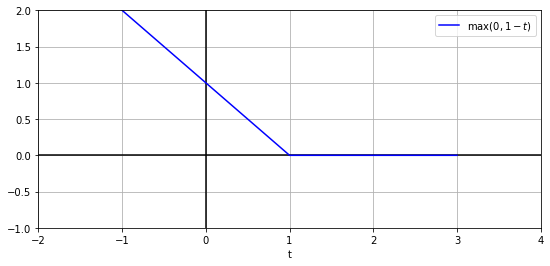

In [8]:
X = np.linspace(-2, 4, 40)
y = np.maximum(X, 0)

plt.figure(figsize=(9, 4))
plt.xlabel('t')
plt.axis([-2, 4, -1, 2])
plt.grid(True)
plt.axvline(x=0, color="k")
plt.axhline(y=0, color="k")
plt.plot(1-X, y, "b-",label=r"$\max(0, 1-t)$")
plt.legend(loc="upper right")
plt.show()

在线SVM也可是实现核技巧，可参考“Incremental and Decremental SVM Learning”, 以及“Fast Kernel Classifier with Online and Active Learning”。但是这些核SVM都是在Matlab和C++上实现的，对于大规模非线性问题，你可能需要使用神经网络。